<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/ml_hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework #7 - Mikołaj Kowalewski, lab group no. 1**

## Scenario A: Fitting a Constant Predictor from Scratch

**Goal:**  
Find the constant value $\lambda$ that minimizes the average binary cross‐entropy loss  
$$
L(\lambda)
= \frac{1}{n}\sum_{i=1}^n\Bigl[-\,y_i\log\sigma(\lambda)\;-\;(1-y_i)\log\!\bigl(1-\sigma(\lambda)\bigr)\Bigr],
$$  
where exactly $m$ of the $n$ labels are 1’s and $k=n-m$ are 0’s.

---

## 1. Loss in Terms of $m$ and $k$

Since $\sigma(\lambda)$ is the same for every data point, we can group terms:  
$$
L(\lambda)
= -\frac{1}{n}\Bigl[m\log\sigma(\lambda)\;+\;k\log\!\bigl(1-\sigma(\lambda)\bigr)\Bigr].
$$

---

## 2. Derivative and Closed-Form Solution

We use  
$$
\frac{d}{d\lambda}\,\sigma(\lambda)
= \sigma(\lambda)\bigl(1-\sigma(\lambda)\bigr).
$$  
Then
$$
\frac{dL}{d\lambda}
= -\frac{1}{n}\Bigl[
m\,\frac{\sigma(\lambda)\bigl(1-\sigma(\lambda)\bigr)}{\sigma(\lambda)}
\;-\;
k\,\frac{\sigma(\lambda)\bigl(1-\sigma(\lambda)\bigr)}{1-\sigma(\lambda)}
\Bigr]
= -\frac{1}{n}\bigl[m\bigl(1-\sigma(\lambda)\bigr)\;-\;k\,\sigma(\lambda)\bigr].
$$  
Setting $\frac{dL}{d\lambda}=0$ gives  
$$
m\bigl(1-\sigma(\lambda)\bigr)
\;=\;
k\,\sigma(\lambda)
\quad\Longrightarrow\quad
\frac{\sigma(\lambda)}{1-\sigma(\lambda)}
=\frac{m}{k}.
$$  
But $\displaystyle\frac{\sigma}{1-\sigma}=e^{\lambda}$, so the solution is  
$$
\boxed{\lambda^* \;=\;\ln\!\bigl(\tfrac{m}{k}\bigr).}
$$

## 3. Interpretation

- **Log-Odds Approach:**  
  $$\lambda^* = \ln\!\bigl(\tfrac{m}{k}\bigr)$$  
  directly equals the log-odds ratio of positives ($m$) to negatives ($k$).

- **Probability Approach:**  
  Passing $$\lambda^*$$ through the sigmoid recovers the fraction of positives:
  $$
    \sigma(\lambda^*)
    = \frac{1}{1 + e^{-\lambda^*}}
    = \frac{m}{m + k}.
  $$

---

# Scenario B: Fitting the $m$-th Predictor in the Forward Stagewise Procedure

In Scenario B we already have previous-stage predictions $f_i$ for each point and seek an additive correction $\lambda$ so that the average binary cross-entropy loss

$$
L(\lambda)
= \frac{1}{n}\sum_{i=1}^n\Bigl[-\,y_i\log\sigma(f_i+\lambda)\;-\;(1-y_i)\log\bigl(1-\sigma(f_i+\lambda)\bigr)\Bigr]
$$

is minimized.

---

## 1. Derivative and Implicit Equation

First note that

$$
\frac{d}{d\lambda}\,\sigma(f_i+\lambda)
= \sigma(f_i+\lambda)\bigl(1-\sigma(f_i+\lambda)\bigr).
$$

Taking the derivative of $L(\lambda)$ gives

$$
\frac{dL}{d\lambda}
= -\frac{1}{n}\sum_{i=1}^n\Bigl[
y_i\,\frac{\sigma(f_i+\lambda)\bigl(1-\sigma(f_i+\lambda)\bigr)}{\sigma(f_i+\lambda)}
\;-\;(1-y_i)\,\frac{\sigma(f_i+\lambda)\bigl(1-\sigma(f_i+\lambda)\bigr)}{1-\sigma(f_i+\lambda)}
\Bigr]
$$

which simplifies to

$$
\frac{dL}{d\lambda}
= -\frac{1}{n}\sum_{i=1}^n\bigl[y_i\bigl(1-\sigma(f_i+\lambda)\bigr)\;-\;(1-y_i)\,\sigma(f_i+\lambda)\bigr]
= -\frac{1}{n}\sum_{i=1}^n\bigl[y_i - \sigma(f_i+\lambda)\bigr].
$$

Setting $\tfrac{dL}{d\lambda}=0$ yields the implicit equation

$$
\sum_{i=1}^n \sigma\bigl(f_i+\lambda^*\bigr)
\;=\;
\sum_{i=1}^n y_i
\quad\Longleftrightarrow\quad
\frac{1}{n}\sum_{i=1}^n \sigma\bigl(f_i+\lambda^*\bigr)
= \frac{m}{n}.
$$

---
## 2. Discussion

In Scenario B we end up with the condition  
$$
\sum_{i=1}^n \sigma\bigl(f_i + \lambda^*\bigr) = m,
$$  
which states that after adding the same shift $\lambda^*$ to each existing logit $f_i$, the total predicted probability must equal the total number of positive labels. Unlike Scenario A, where every point saw the identical argument $\lambda$ inside the sigmoid—allowing us to factor out $n\,\sigma(\lambda)$ and invert the sigmoid in closed form—here each term is $\sigma(f_i + \lambda)$ with a different offset $f_i$. Because the logistic function $\sigma(z)=1/(1+e^{-z})$ is nonlinear, a sum of shifted sigmoids cannot be collapsed or inverted algebraically into a single expression in $\lambda$. Consequently, there is no analogue of the simple log‐odds solution $\lambda^*=\ln(m/k)$, and we must instead compute $\lambda^*$ using numerical methods.

---
We will now explore the loss landscape in both scenarios in Python. We chose to consider drawing the predictions $f_i$ from 3 different variants of the centered normal distribution - we increased the variance each time. This helps accentuate the differences between the two curves that resulted from the scenarios we have been researching.


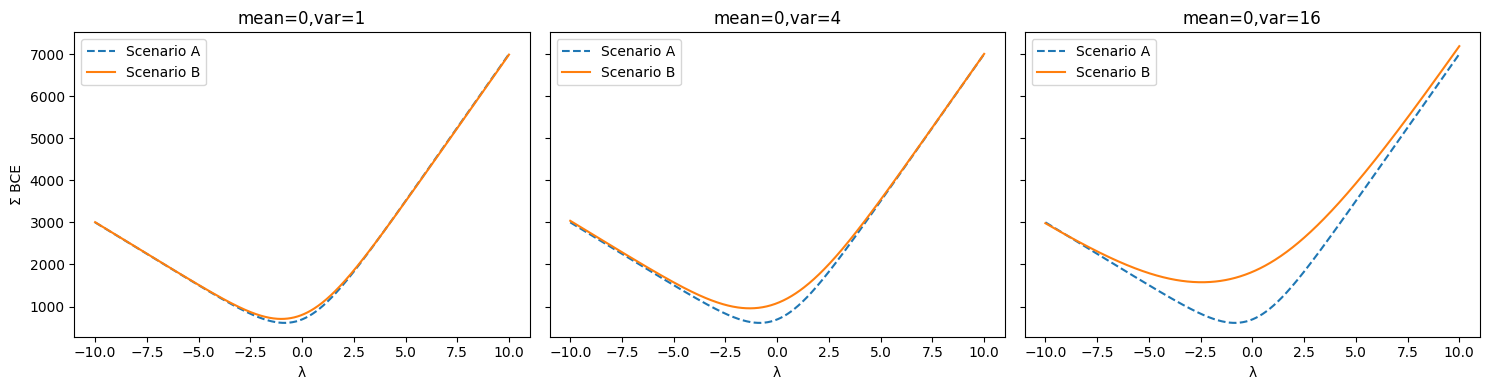

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n, m = 1000, 300
k = n - m
y = np.concatenate([np.ones(m), np.zeros(k)])
np.random.shuffle(y)

sigmoid = lambda z: 1/(1 + np.exp(-z))
bce     = lambda y, z: -np.sum(y * np.log(sigmoid(z)) + (1-y) * np.log(1-sigmoid(z)))
lams    = np.linspace(-10, 10, 500)

lossA = np.array([bce(y, lam) for lam in lams])

# Defining three different f_prev’s
fps = {
    'mean=0,var=1':  np.random.randn(n),
    'mean=0,var=4':  2*np.random.randn(n),
    'mean=0,var=16': 4*np.random.randn(n),
}

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
for ax, (label, f_prev) in zip(axes, fps.items()):
    lossB = np.array([bce(y, f_prev + lam) for lam in lams])
    ax.plot(lams, lossA, '--', label='Scenario A')
    ax.plot(lams, lossB,  label='Scenario B')
    ax.set(title=label, xlabel='λ')
    ax.legend()

axes[0].set(ylabel='Σ BCE')
plt.tight_layout()
plt.show()



## Discussion

From the plots we see that both Scenario A and Scenario B exhibit a single, smooth bowl-shaped curve with exactly one global minimum — so in both cases the loss is unimodal and strictly convex. The loss landscape in Scenario A is simpler – it does not depend on the individual prior predictions, only on how many labels are positive versus negative. The curve itself is steeper than in scenario B, which makes locating the minimum via line search or root-finding both faster and more reliable. A steeper bowl, which implies a larger second derivative, means brackets contract more quickly in Brent’s or golden-section searches, and Newton–Raphson steps are more decisive. In Scenario B the curve remains unimodal but becomes wider and can shift  as the variance of the prior predictions $f_i$ increases. Despite these changes in shape, there are no additional local minima — so it is perfectly reasonable to find the unique minimizer numerically (using perhaps the Brent's method or the Newton-Raphson algorithm).

The extra difficulty in Scenario B does not come from a multimodal or pathological loss landscape, but rather from the nonlinearity of the sigmoid combined with heterogeneous offsets $f_i$. Because each term in the sum we were considering in the theoretical part $σ(f_i + \lambda)$ came with a different $f_i$, it was not possible to algebraically factor out and invert a single sigmoid as in Scenario A. Thus, it is necessary to resort to numerical optimization in that case.

